# The Reuters corpus

### Our question is: Can we distinguish different authors based on writing style and sentiment score?

Import packages:

In [1]:
# text analysis
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
import random

# clustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# pandas and numpy
import pandas as pd
import numpy as np

# for plots
import matplotlib.pyplot as plt
import seaborn as sns

# logistic regression for prediction
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


# hide warnings
import warnings
warnings.filterwarnings("ignore")

### Load the documents and clean the articles

In [2]:
data_dir = "..STA380/data/"
nltk.data.path.append(os.path.abspath(data_dir))
nltk.download('stopwords', download_dir=data_dir)
nltk.download('reuters', download_dir=data_dir)
nltk.download('punkt', download_dir=data_dir)

[nltk_data] Downloading package stopwords to ..STA380/data/...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package reuters to ..STA380/data/...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to ..STA380/data/...
[nltk_data]   Package punkt is already up-to-date!


True

Read the documents:

In [3]:
def read_data_from_directory(directory_path):
    authors = os.listdir(directory_path)
    texts = []
    labels = []
    for author in authors:
        author_path = os.path.join(directory_path, author)
        if not os.path.isdir(author_path):
            continue
            
        for file_name in os.listdir(author_path):
            file_path = os.path.join(author_path, file_name)
            if not os.path.isfile(file_path) or not file_name.endswith('.txt'):
                continue
            with open(file_path, 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(author)
    return texts, labels

Load the articles and authors into the variables:

In [4]:
train_texts, train_labels = read_data_from_directory('/Users/eva/downloads/STA380 - Intro to Machine Learning/Exercises/STA380/data/ReutersC50/C50train/')
test_texts, test_labels = read_data_from_directory('/Users/eva/downloads/STA380 - Intro to Machine Learning/Exercises/STA380/data/ReutersC50/C50test/')

Clean the articles and get rid of the stop words:

In [5]:
# Functions to tokenize, remove punctuation, and stem
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation and token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return stemmed_tokens


Clustom Tokenizer:

In [6]:
vectorizer = CountVectorizer(tokenizer=preprocess_text, stop_words='english', max_features=2500)
train_dtm = vectorizer.fit_transform(train_texts)
test_dtm = vectorizer.transform(test_texts)

#### Before we start our analysis, we want to look at what are the common words that the authors have collectively used in the articles in the dataset.

In [7]:
unique_authors = list(set(train_labels))
selected_authors = random.sample(unique_authors, 10)

filtered_indices = [i for i, label in enumerate(train_labels) if label in selected_authors]
filtered_texts = [train_texts[i] for i in filtered_indices]
filtered_labels = [train_labels[i] for i in filtered_indices]
filtered_dtm = train_dtm[filtered_indices]

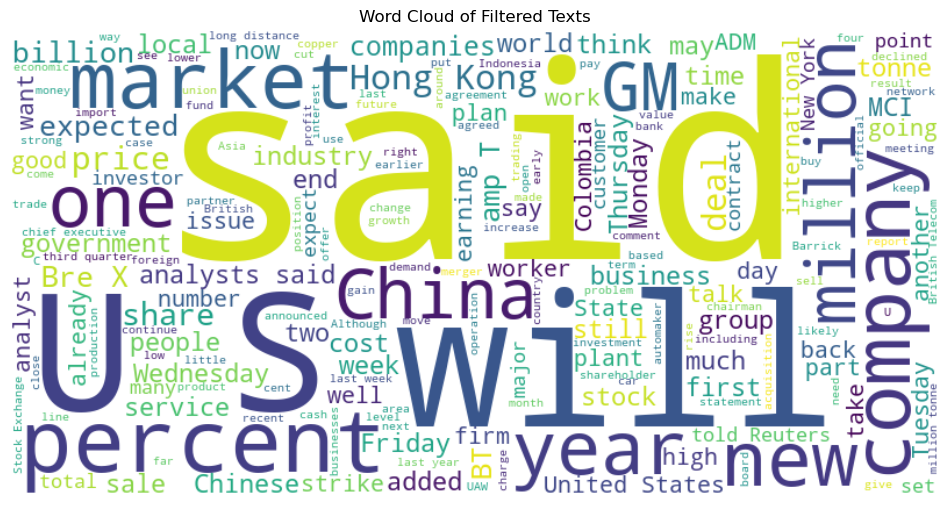

In [8]:
from wordcloud import WordCloud
# Create a word cloud of terms from filtered texts
text = " ".join(filtered_texts)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
# Plot word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Filtered Texts')
plt.show()

### Approach (a)
#### To explore whether we can distinguish authors based on their writing styles, we employed tSNE and PCA with k-means clustering. We also did a logistic regression to predict the authors of the articles in the test set.

Use PCA to reduce the dimensionality first:

In [9]:
pca = PCA(n_components=100)
reduced_data_pca = pca.fit_transform(train_dtm.toarray())

Run tSNE on the dimensionality-reduced dataset:

In [10]:
tsne = TSNE(n_components=2, perplexity=20)
tsne_results = tsne.fit_transform(reduced_data_pca)

Plot a tSNE graph:

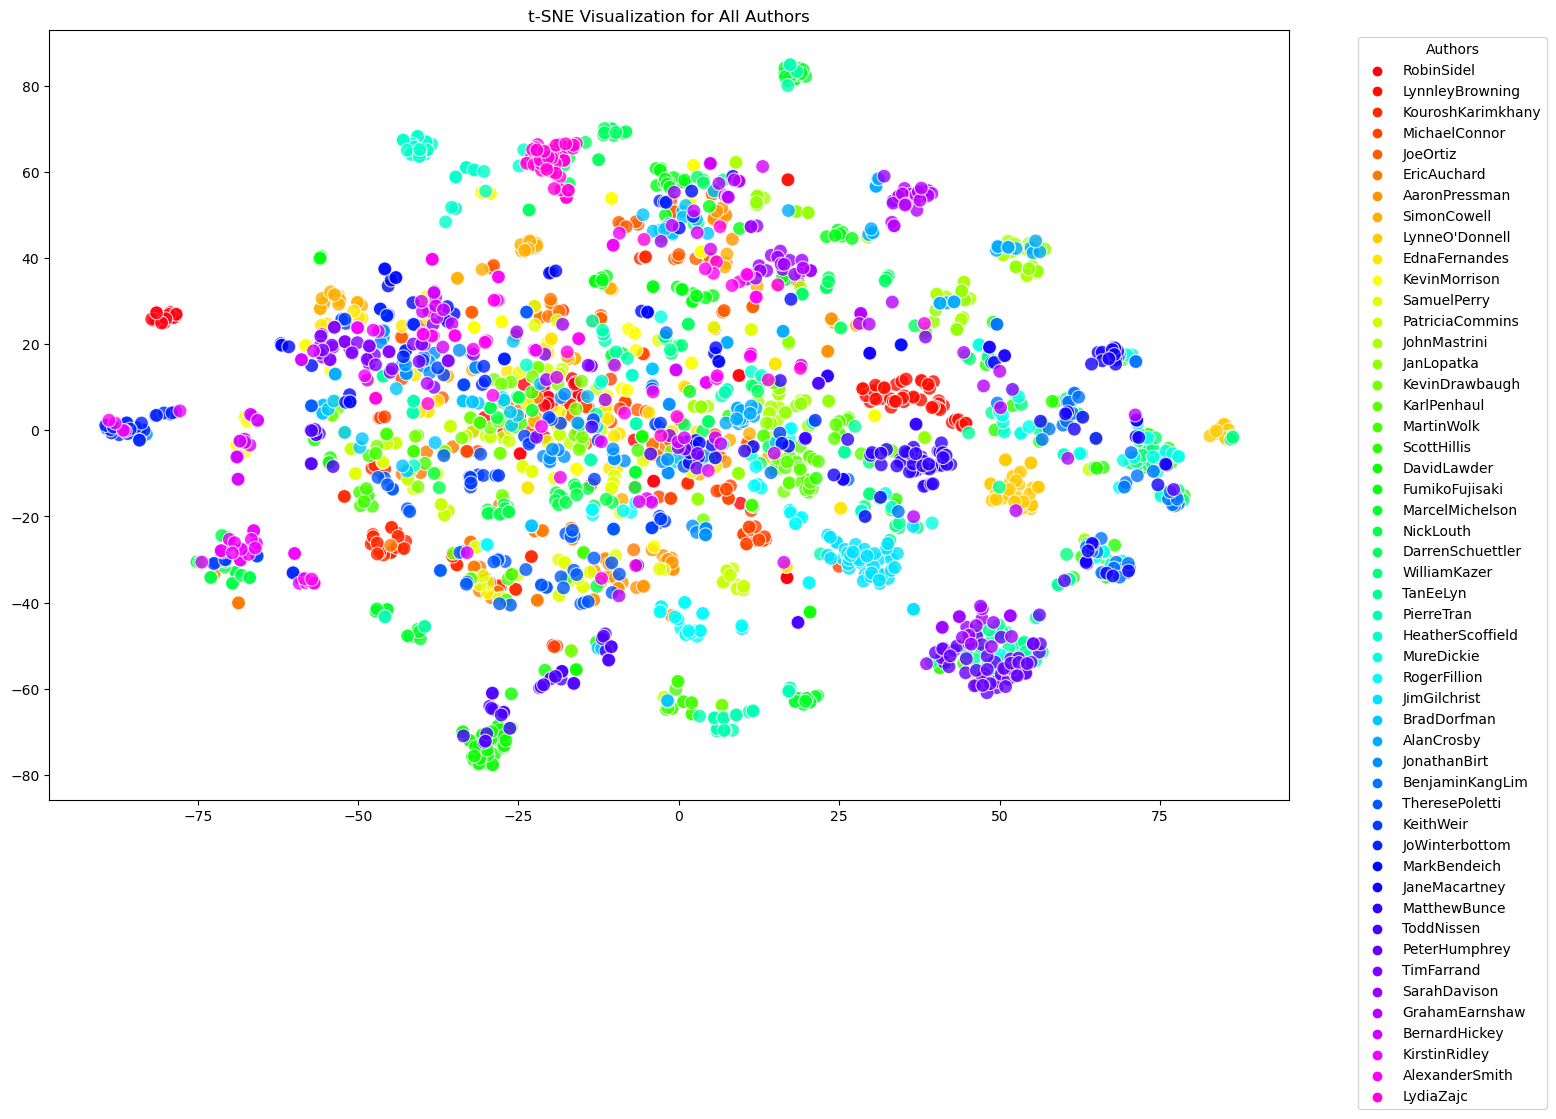

In [11]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=train_labels,
    palette=sns.color_palette('gist_rainbow', len(list(set(train_labels)))),
    alpha=0.8,
    s=100
)
plt.title('t-SNE Visualization for All Authors')
plt.legend(title='Authors', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Cluster the articles by authors using PCA

Plot the cumulative variance explained by n_components:

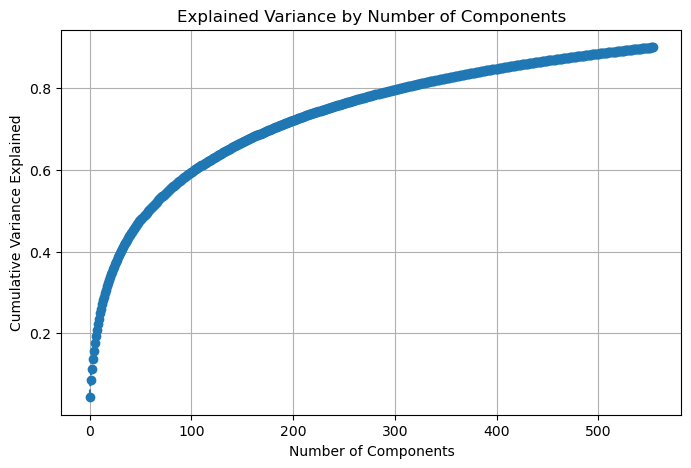

In [12]:
train_dtm_dense = train_dtm.toarray()

# Apply PCA
pca = PCA(n_components=0.9)  # Adjust n_components to retain 90% of variance to restrain the size of the plot
pca.fit(train_dtm_dense)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

Run PCA with n_components = 2:

In [13]:
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_dtm.toarray())

Build a dataframe on the the PCAs and look at the coefficients:

In [14]:
pca_components = pca.components_
feature_names = vectorizer.get_feature_names_out()

components_df = pd.DataFrame(data=pca_components, columns=feature_names, index=['PCA_1', 'PCA_2'])
components_df

,'','d,'ll,'m,'re,'s,'ve,+44,--,..,...,yokich,york,young,yuan,zealand,zeman,zemin,zhang,zhou,zinc
PCA_1,0.437725,0.003108,0.004734,0.002257,0.027487,0.294859,0.014343,-0.001988,0.045178,0.002042,...,-0.002220,0.009202,0.000722,0.011969,0.001793,-0.003193,-0.001293,-0.001010,-0.002572,0.00360
PCA_2,0.148881,-0.000007,-0.000194,0.004673,-0.004448,0.177581,-0.001198,-0.003169,0.008107,-0.001832,...,0.002376,-0.010803,0.001251,0.011154,-0.001787,0.001584,0.011166,0.005029,0.007134,0.00388


Plot a scatter plot of PCA 1 and PCA 2 to see if PCA is capturing the differences in writing styles between authors:

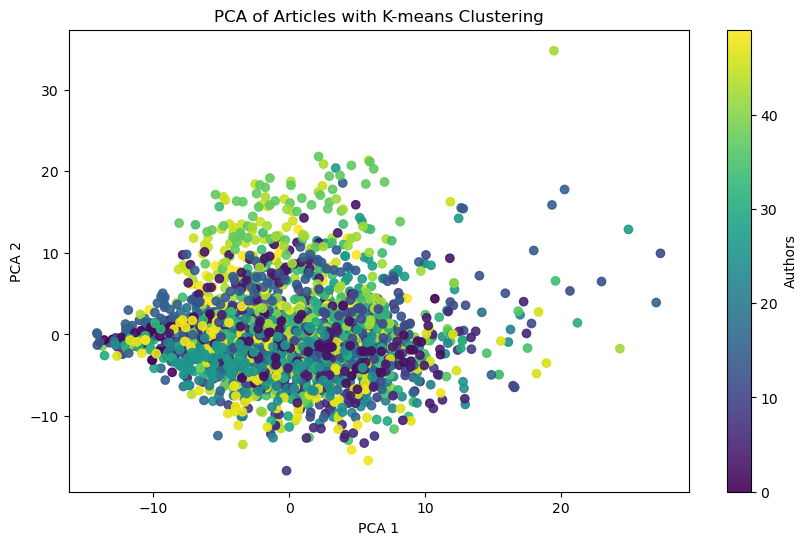

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(train_pca[:, 0], train_pca[:, 1], c=LabelEncoder().fit_transform(train_labels), cmap='viridis', alpha=0.9)
plt.title('PCA of Articles with K-means Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Authors')
plt.show()

Run a logistic regression model on the training set, predict on the test set, and get the classification report:

In [16]:
model = LogisticRegression(max_iter=1000)
model.fit(train_dtm, train_labels)

predictions = model.predict(test_dtm)

print("\nClassification Report:")
print(classification_report(test_labels, predictions))



Classification Report:
                   precision    recall  f1-score   support

    AaronPressman       0.83      0.86      0.84        50
       AlanCrosby       0.97      0.58      0.72        50
   AlexanderSmith       0.75      0.48      0.59        50
  BenjaminKangLim       0.38      0.32      0.35        50
    BernardHickey       0.65      0.68      0.67        50
      BradDorfman       0.51      0.80      0.62        50
 DarrenSchuettler       0.46      0.24      0.32        50
      DavidLawder       0.75      0.42      0.54        50
    EdnaFernandes       0.64      0.60      0.62        50
      EricAuchard       0.55      0.56      0.55        50
   FumikoFujisaki       1.00      0.90      0.95        50
   GrahamEarnshaw       0.77      0.80      0.78        50
 HeatherScoffield       0.36      0.40      0.38        50
       JanLopatka       0.66      0.62      0.64        50
    JaneMacartney       0.29      0.34      0.31        50
     JimGilchrist       0.94   

Plot a confusion matrix of the predictions:

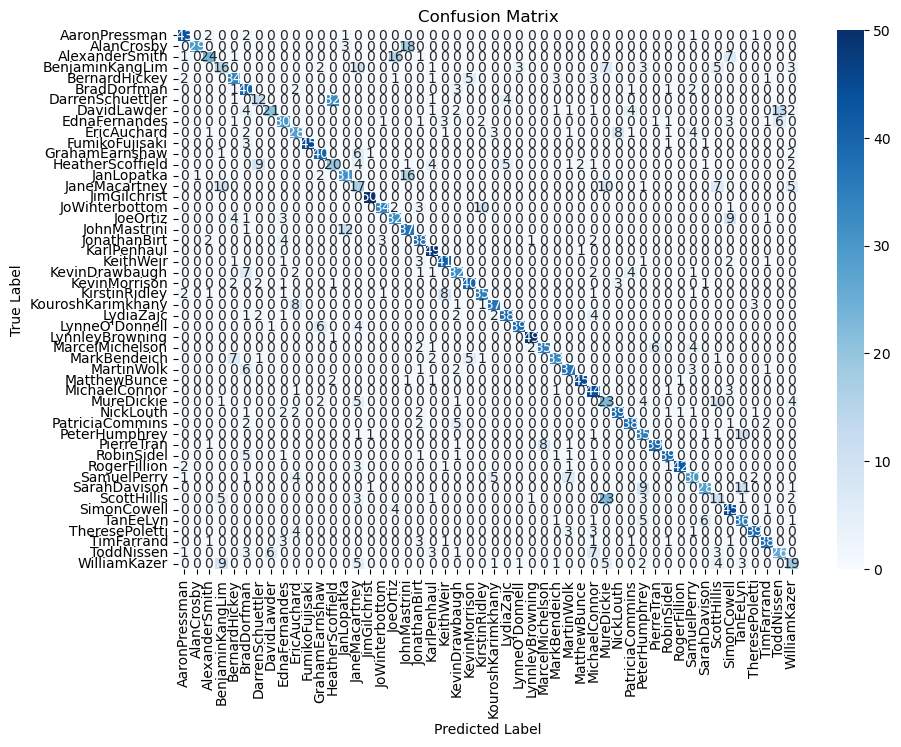

In [17]:
cm = confusion_matrix(test_labels, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Result
#### The t-SNE analysis was inconclusive in distinguishing clear clusters based on authors' writing styles, as the clusters overlapped significantly. The PCA analysis revealed that while 100 components would best capture the variance, reducing to 2 components for interpretability did not result in distinct clusters of authors. It is hard to distinguish authors based on their text/writing style.
#### We implemented logistic regression, random forest, and boosting algorithms to predict the authors of articles based on their writing styles. Among these, logistic regression yielded the highest accuracy, approximately 69%. From the confusion matrix, we observe that the model performs exceptionally well on certain authors. For instance:
- #### Jim Gilchrist: The model correctly identified 50 out of 51 articles.
- #### Karl Penhaul and Lynnley Browning: The model made 49 correct predictions for each author.

#### However, for many other authors, the correct prediction rate drops, with only 30-40 articles being accurately predicted.

### Conclusion
#### Overall, clustering is hard to group authors based on writing style but prediction models are slightly better when distinguishing the writing style. While the logistic regression model has strengths in identifying certain writing styles, it struggles with others, indicating potential areas for improvement, such as exploring more advanced features. <br><br>

### Approach (b)
#### Then, we conducted a sentiment analysis on the Reuters C50 corpus, combining both the training and test sets, using the VADER sentiment analyzer. The analysis was enhanced with PCA and k-means clustering to explore relationships between authors based on their sentiment profiles. The elbow plot suggested 6 optimal clusters.

Download VADER:

In [18]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/eva/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Write a function that computes the sentiment scores of a list of texts:

In [19]:
def get_sentiment_scores(texts):
    sentiment_scores_list = []
    for text in tqdm(texts, desc="Analyzing sentiment"):
        sentiment_scores = sia.polarity_scores(text)
        sentiment_scores_list.append(sentiment_scores)
    return sentiment_scores_list

Compute the sentiment score of each author. Note: We used both the training texts and the test texts in this section.

In [20]:
train_sentiment_scores = get_sentiment_scores(train_texts)
train_sentiment_df = pd.DataFrame(train_sentiment_scores)
train_sentiment_df['label'] = train_labels

test_sentiment_scores = get_sentiment_scores(test_texts)
test_sentiment_df = pd.DataFrame(test_sentiment_scores)
test_sentiment_df['label'] = test_labels

train_avg_sentiment_by_author = train_sentiment_df.groupby('label')[['neg', 'neu', 'pos', 'compound']].mean()
test_avg_sentiment_by_author = test_sentiment_df.groupby('label')[['neg', 'neu', 'pos', 'compound']].mean()
combined_avg_sentiment_by_author = (train_avg_sentiment_by_author + test_avg_sentiment_by_author) / 2

print("Average Sentiment Scores for Each Author:")
print(combined_avg_sentiment_by_author)


Analyzing sentiment: 100%|█████████████████| 2500/2500 [00:12<00:00, 199.21it/s]

Average Sentiment Scores for Each Author:
                       neg      neu      pos  compound
label                                                 
AaronPressman      0.05146  0.85720  0.09132  0.544729
AlanCrosby         0.05787  0.84193  0.10021  0.551951
AlexanderSmith     0.05073  0.84985  0.09932  0.543744
BenjaminKangLim    0.10605  0.82782  0.06605 -0.509847
BernardHickey      0.04127  0.85104  0.10775  0.710662
BradDorfman        0.03746  0.86755  0.09495  0.671990
DarrenSchuettler   0.06224  0.85312  0.08460  0.289222
DavidLawder        0.04667  0.86196  0.09134  0.664449
EdnaFernandes      0.05541  0.85272  0.09181  0.533657
EricAuchard        0.03033  0.88168  0.08807  0.811327
FumikoFujisaki     0.09048  0.81590  0.09368 -0.053367
GrahamEarnshaw     0.05804  0.84229  0.09962  0.561373
HeatherScoffield   0.05013  0.85551  0.09429  0.610100
JanLopatka         0.05897  0.86519  0.07582  0.333093
JaneMacartney      0.08048  0.82590  0.09365  0.280656
JimGilchrist       0.02

Plot the sentiment scores for each author:

<Figure size 1600x1000 with 0 Axes>

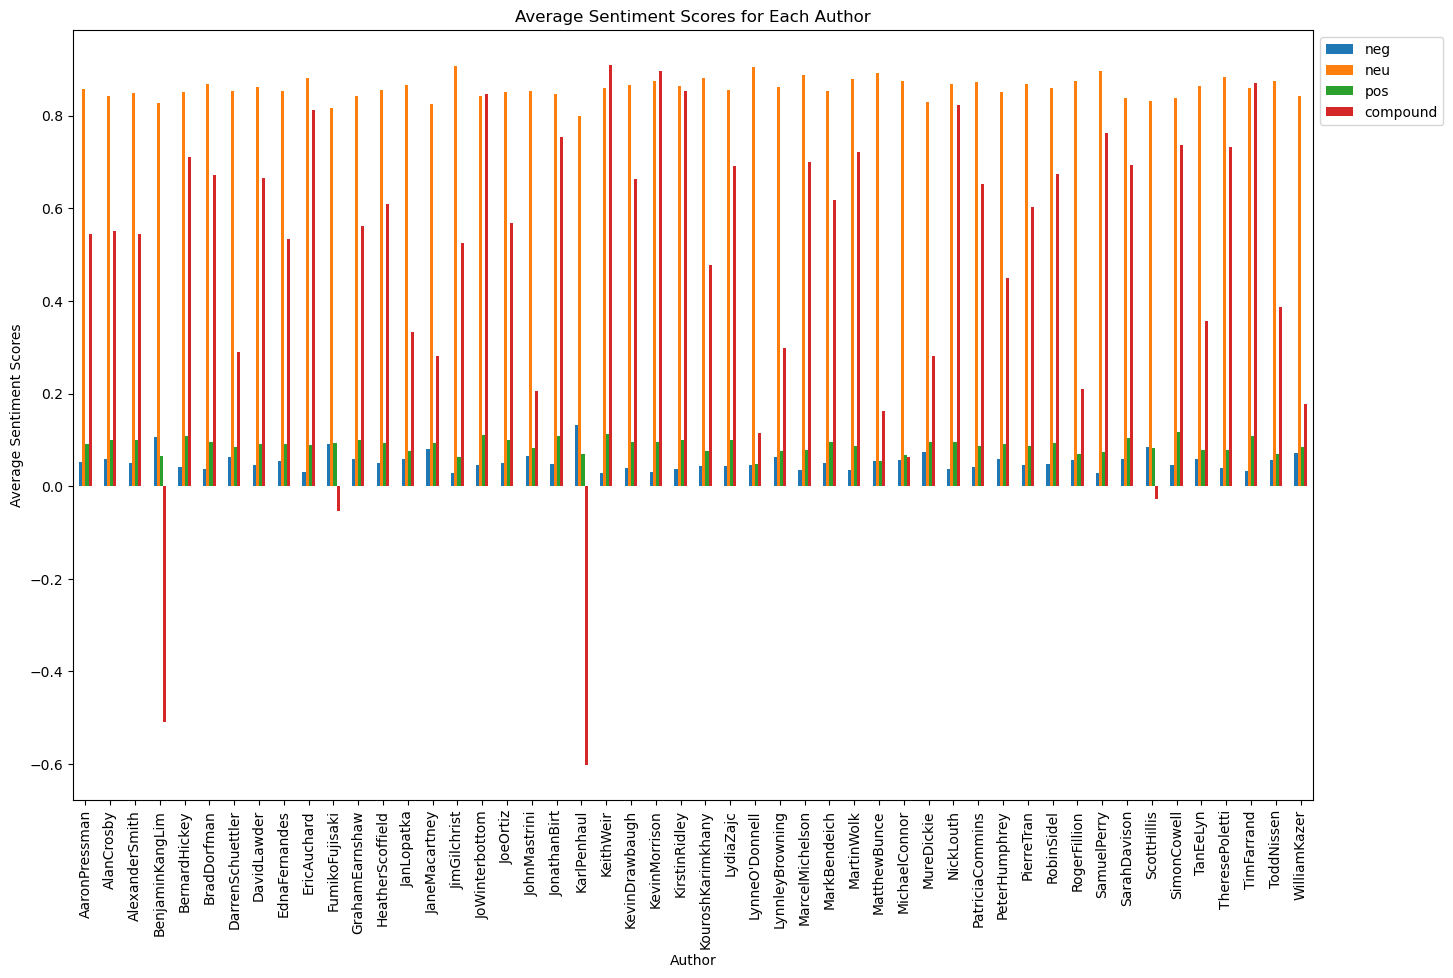

In [21]:
# Visualize the clusters with a bar plot
plt.figure(figsize=(16, 10))
plot = combined_avg_sentiment_by_author.plot(kind='bar', figsize=(16, 10))
plt.title('Average Sentiment Scores for Each Author')
plt.xlabel('Author')
plt.ylabel('Average Sentiment Scores')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

### K-means clustering by combined average sentiment score

Plot an elbow plot to select the number of cluster:

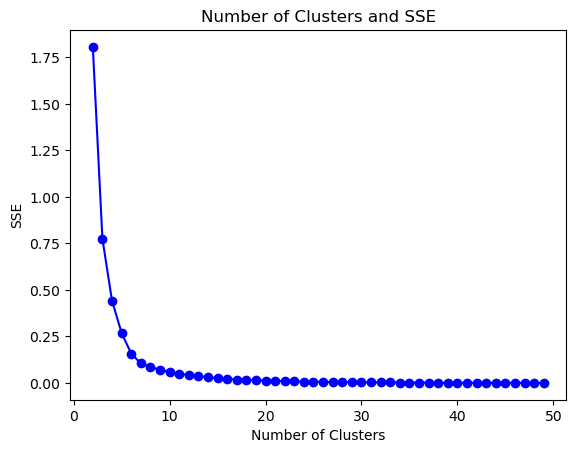

In [22]:
sse = []
for i in range(2, 50):
    kmeans = KMeans(n_clusters=i, random_state=1)
    kmeans.fit(combined_avg_sentiment_by_author)
    sse.append(kmeans.inertia_)
    
plt.plot(range(2, 50), sse, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Number of Clusters and SSE')
plt.show()

Run a K-means clustering algorithm with 6 clusters on the authors' sentiment dataframe:

In [23]:
kmeans = KMeans(n_clusters=6, random_state=42)  # Adjust n_clusters as needed
clusters = kmeans.fit_predict(combined_avg_sentiment_by_author)

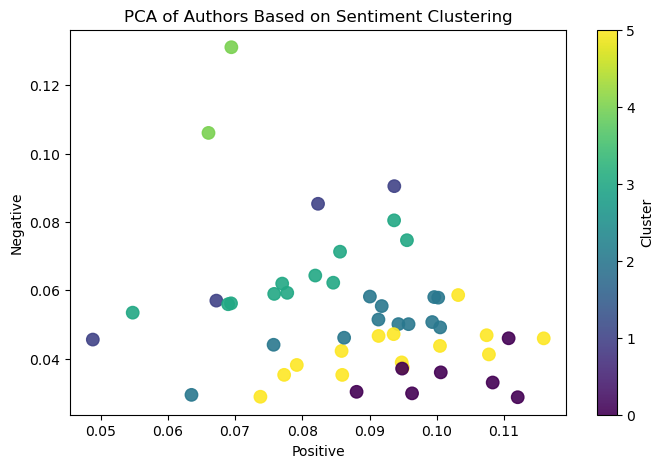

In [24]:
plt.figure(figsize=(8, 5))
scatter = plt.scatter(combined_avg_sentiment_by_author['pos'], combined_avg_sentiment_by_author['neg'], c=clusters, cmap='viridis', alpha=0.9, s=80)
plt.title('PCA of Authors Based on Sentiment Clustering')
plt.xlabel('Positive')
plt.ylabel('Negative')
plt.colorbar(scatter, label='Cluster')
plt.show()

### Result
#### The sentiment analysis revealed that most authors exhibited generally positive or neutral sentiment. However, several authors, including Benjamin Kang Lim, Fumiko Fujisaki, Karl Penhaul, and Scott Hillis, stood out with notably negative compound scores. In particular, Benjamin Kang Lim and Karl Penhaul displayed significantly negative sentiment, as evidenced by the k-means clustering plot. In the plot, there are two distinct points with high negative sentiment, grouped into a separate cluster, which further highlights the strong negative tone present in their articles.

### Conclusion
#### The clustering analysis highlighted that while most authors maintain a balanced sentiment distribution, a few express significantly more negative sentiments, potentially reflecting the topics they cover or their writing styles. These differences in sentiment are distinct enough to form separate groups, suggesting discernible patterns in the emotional tone across the corpus. Based on senstiment analysis, it’s clearer to group authors. However, it is essential to note that sentiment analysis tools like VADER have limitations. They are based on word choice and lexicons, which may not always capture the deeper context as a human reader might.



<br><br><br><br><br><br><br><br>